# UTILS


## imports

In [ ]:
from json import loads,load
from PIL import Image
import os
from pprint import pprint
import os,cv2,keras
import pandas as pd
!pip install selective_search
from selective_search import selective_search
from time import time
import numpy as np
import urllib 
from math import log,exp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow.keras as kk
from keras import backend as K
from tensorflow.keras.applications import mobilenet_v2,InceptionResNetV2,efficientnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import NumpyArrayIterator
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf
import imageio
import tensorflow_datasets as tfds
 
from tensorflow.keras.layers import Layer
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
cv2.setUseOptimized(True)
cv2.setNumThreads(8)
from zipfile import ZipFile
# Load the TensorBoard notebook extension.
%load_ext tensorboard
from datetime import datetime
import io
import itertools
from packaging import version
from six.moves import range
 
import tensorflow as tf
from tensorflow import keras
 
import matplotlib.pyplot as plt
import numpy as np
import sklearn.metrics
 
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >= 2, \
    "This notebook requires TensorFlow 2.0 or above."

  Created wheel for selective-search: filename=selective_search-0.1.2.2-cp36-none-any.whl size=8980 sha256=a7dc654ccbda58cdfa6add27d6162124600d9a22f9f7289a5ef4e8ba4644d1be
  Stored in directory: /root/.cache/pip/wheels/c9/a2/90/f19103d79bf171dbce304996899567f97cb480737408050071
Successfully built selective-search
TensorFlow version:  2.3.0


## Functions

In [ ]:
IR = 8e-5
NUM_EPOCHS = 20
NUM_STEPS = 230


# create the base pre-trained model
@tf.function
def get_iou_m(boxA, boxB):
  ba0 = boxA[...,0] 
  ba1 = boxA[...,1]
  ba2 = boxA[...,2] + ba0
  ba3 = boxA[...,3] + ba1
  bb0 = boxB[...,0]
  bb1 = boxB[...,1]
  bb2 = boxB[...,2] + bb0
  bb3 = boxB[...,3] + bb1
  xA = tf.where (ba0-bb0>0,ba0,bb0)
  yA = tf.where (ba1-bb1>0,ba1,bb1)
  xB = tf.where (ba2-bb2<0,ba2,bb2)
  yB = tf.where (ba3-bb3<0,ba3,bb3)
  interArea = tf.abs(tf.where((xB - xA)>0,xB - xA,0) * tf.where((yB - yA)>0,yB - yA,0))
  boxAArea = tf.abs(boxA[...,2] * boxA[...,3])
  boxBArea = tf.abs(boxB[...,2] * boxB[...,3])
  iou = interArea / (boxAArea + boxBArea - interArea)
  return iou


@tf.function
def loss_class(y_true, y_pred):
    inp =  tf.square(y_pred - y_true)
    loss1 = 1.0 -  tf.where(inp[...,0]>90 ,1.0,get_iou_m(y_true, y_pred))
    loss2 = inp[...,4]
    loss3 = tf.reduce_sum(tf.where(inp[...,:4]>100 ,0.0,inp[...,:4]) * .1,axis=-1) 
    return loss1 + loss2  + loss3 * 10

def get_yolo_model(IR = .1,tb = False,m=.9):
  model = Sequential()
  model.add(Input(shape=(448,448,3)))  # 250x250 RGB images
  model.add(Conv2D(filters = 64,kernel_size=(7,7), strides=2, activation="tanh",padding='same'))
  model.add(MaxPooling2D((2,2),strides=2))
  ################################################################################
  model.add(Conv2D(filters = 192,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(MaxPooling2D((2,2),strides=2))
  ################################################################################
  model.add(Conv2D(filters = 128,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 256,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 256,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(MaxPooling2D((2,2),strides=2))
  ################################################################################
  model.add(Conv2D(filters = 256,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 256,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 256,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 256,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=2, activation="tanh",padding='same'))
  ##################################################################################
  model.add(Conv2D(filters = 512,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 512,kernel_size=(1,1), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=2, activation="tanh",padding='same'))
  ##################################################################################
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Conv2D(filters = 1024,kernel_size=(3,3), strides=1, activation="tanh",padding='same'))
  model.add(Dense(1024, activation='tanh'))
  # model.add(Dropout(.1))
  model.add(Dense(512, activation='tanh'))
  # model.add(Dropout(.1))
  model.add(Dense(128, activation='tanh'))
  # model.add(Dropout(.1))
  model.add(Dense(30, activation='tanh'))
  opt = SGD(learning_rate=IR, momentum=m, decay= IR*.1/20  )
  # opt = Adam(learning_rate=IR)
  # if tr == 'c':
  # lss = loss_class
  # else:
  #   lss = loss_loc
  model.compile(loss=loss_class, optimizer=opt)
  model.summary()
  print("model created")
  return model



m = get_yolo_model()


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_120 (Conv2D)          (None, 224, 224, 64)      9472      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 112, 112, 192)     110784    
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 56, 56, 192)       0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 56, 56, 128)       24704     
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 256)       295168    
_________________________________________________________________
conv2d_124 (Conv2D)          (None, 56, 56, 256)      

## Custom Class

GROUP BOX

In [ ]:
# human dataset
from math import log

def get_iou(boxA, boxB):
  # determine the (x, y)-coordinates of the intersection rectangle
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])

  # compute the area of intersection rectangle
  interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
  if interArea == 0:
      return 0
  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = abs((boxA[2] - boxA[0]) * (boxA[3] - boxA[1]))
  boxBArea = abs((boxB[2] - boxB[0]) * (boxB[3] - boxB[1]))

  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return iou

class GRect():
  def __init__(self,tup):
    x,y,w,h = tup
    self.x = x
    self.y = y
    self.w = w
    self.h = h
    self.g = -1
    self.p = 0

  def right(self):
    return self.x + self.w
  
  def left(self):
    return self.x

  def top(self):
    return self.y

  def bottom(self):
    return self.y + self.h

  def have_inter(self,rect):
    return (self.left() < rect.right() and self.right() > rect.left() and
     self.top() < rect.bottom() and self.bottom() > rect.top() ) or rect.in_rect(self) or self.in_rect(rect)

  def tup(self):
    return (self.x,self.y,self.w,self.h)

  def in_rect(self,rect):
    return (rect.right() < self.right() and rect.left() > self.left() and 
            rect.top() > self.top() and rect.bottom() < self.bottom()) 
    
  def get_iou(self,rect):
    return get_iou(
        [self.left(),self.top(),self.right(),self.bottom()],
        [rect.left(),rect.top(),rect.right(),rect.bottom()]
    )


def group_rects(rects,points):

  rects = list(map(lambda x:GRect(x),rects))
  groups = 0
  for i in range(len(rects)):
    rects[i].p = points[i]
    g = -1
    inters = []
    for j in range(len(rects)):
      if rects[i].have_inter(rects[j]):
        inters.append(j)
        g = max(g,rects[j].g)
    
    if g == -1:
      g = groups = groups + 1
      print(g)

    rects[i].g = g
    for k in  inters:
      rects[k].g = g
  # print(groups)
  grouped_rects = [[] for _ in range(groups)]
  for rect in rects:
    grouped_rects[rect.g-1].append(rect)
  final_rects = []

  for g_rects in grouped_rects:
    x = y = w = h = p = 0
    for rect in g_rects:
      rectp = rect.p
      x += rect.x * rectp
      y += rect.y * rectp
      w += rect.w * rectp
      h += rect.h * rectp
      p += rectp
    print(p)
    if p == 0 :
      continue
    final_rects.append((x/p,y/p,w/p,h/p))
  
  return final_rects


def group_rects_v2(rects,points):
  groups = -1
  rects = list(map(lambda x:GRect(x),rects))
  l = len(rects)
  ious = [0 for _ in range(l)]

  for i in range(l):
    rects[i].p = points[i]
    rects[i].g = -1
    for j in range(l):
        ious[i] += rects[i].get_iou(rects[j])
  
  mean_iou = sum(ious) / len(ious)

  for i in range(l):
    if ious[i] >= mean_iou:
      if rects[i].g == -1:
        groups += 1
        rects[i].g = groups

      for j in range(l):
        if rects[i].get_iou(rects[j]) > .1:
          rects[j].g = rects[i].g

  remain_rects = []
  remain_point = []
  grects = [[] for _ in range(groups+1)]
  for i in range(l):
    rect = rects[i]
    if rect.g == -1:
      remain_rects.append((rect.x,rect.y,rect.w,rect.h))
      remain_point.append(rect.p)
    else:
      grects[rect.g].append(rect)
  total = []
  for g in grects:
    p = x = y = w = h = 0
    for rect in g:
      p+= rect.p
      x+= rect.x * rect.p
      y+= rect.y * rect.p
      w+= rect.w * rect.p
      h+= rect.h * rect.p
    if p == 0 :
      continue
    
    total.append((x/p,y/p,w/p,h/p))
  extra = []
  if len(remain_rects) > 0:
    extra = group_rects_v2(remain_rects,remain_point)
  total.extend(extra)
  return total

In [ ]:
GRect((0,0,1,1)).have_inter(GRect((.5,.5,1,1)))

True

# Download AND GENERATE IMAGES

## Download images

In [ ]:
%rm -r train/ 
%rm -r validation/
%mkdir -p {train,validation}/

rm: cannot remove 'train/': No such file or directory
rm: cannot remove 'validation/': No such file or directory


generate loc_images

In [ ]:
%cd 
%cd /content/
%cp /content/drive/My\ Drive/zipFiles/train/*.odgt /content/
 
base_path = '/content/drive/My Drive/zipFiles/train/'
 
with ZipFile(base_path+ 'CrowdHuman_train01.zip', 'r') as zipObj:
   zipObj.extractall()
with ZipFile(base_path+'CrowdHuman_train02.zip', 'r') as zipObj:
   zipObj.extractall()
with ZipFile(base_path + 'CrowdHuman_train03.zip', 'r') as zipObj:
   zipObj.extractall()

In [ ]:
S = 7
D = 5
counter = 0
outputs = []
from skimage.transform import resize
# for typ in ["validation","train"]:
for typ in ["train"]:
  ds = tfds.load(
      "voc",
      split=typ, 
      data_dir='/content/drive/My Drive/kar/dataset'
  )
  
  for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}` 
    image = example["image"]
    label = example["objects"]["label"]
    boxes = example["objects"]["bbox"]
    diff = example["objects"]["is_difficult"]
    box_label = list(filter(lambda x:x[1]==14 and x[2] == False,zip(boxes,label,diff)))
    if len(box_label) >= 1:
      boxes,label,diff = zip(*box_label)
      # print(image.shape)
 
    else:
      continue
      boxes,label,diff = [],[],[]
    image = image.numpy()
    boxes = list(map(lambda x:x.numpy(),boxes))
    output = [[[0 for _ in range(D)] for _ in range(S)] for _ in range(S)]
    # print(boxes)
    for i in range(S):
      for j in range(S):
        px = i / 7.0
        py = j / 7.0
        pw = 1 / 7.0
        ph = 1 / 7.0
        iou_points = list(map(lambda x :get_iou([px,py,px+pw,py+ph],x),boxes))
        if sum(iou_points) == 0:
          output[i][j][0] = -120
          output[i][j][1] = -120
          output[i][j][2] = -120
          output[i][j][3] = -120
        else:
          idx = iou_points.index(max(iou_points))
          output[i][j][0] = boxes[idx][0] - px
          output[i][j][1] = boxes[idx][1] - py
          output[i][j][2] = log((boxes[idx][2] - boxes[idx][0])*7.0)
          output[i][j][3] = log((boxes[idx][3] - boxes[idx][1])*7.0)
        point = -1 if sum(iou_points) < 1.0 / 49.0 else 1
        output[i][j][4] = point
    # show_image_with_rect_xy(image,[boxes[0]*[480,389,480,389]])
    # show_detected_area(tf.constant(np.array([output])))
    imageio.imwrite('/content/train/'+str(counter)+".jpg",image.astype(np.uint8) )
    outputs.append(output[:])
    counter += 1 
    # if counter > 1:
    #   break
 
 
      
 
print(counter)
# from json import dump
# %rm output.txt
del ds
# with open("output.txt","w") as fp:
# np.save("output.txt",np.array(outputs))
 
# %ls loc_images

1025


## CROWD

In [ ]:
S = 7
D = 5
 
 
 
with open('annotation_train.odgt') as fp:
  for line in fp.readlines():
    anot = loads(line)
    if not os.path.exists("./Images/"+anot["ID"]+".jpg"):
      continue
    image = Image.open("./Images/"+anot["ID"]+".jpg")
    h,w = image.size
    humans = []
    for box in anot['gtboxes']:
      if box['tag'] == 'person':
         humans.append([box["vbox"][1]/w,box["vbox"][0]/h,box["vbox"][3]/w,box["vbox"][2]/h])
    if not (0 <len(humans) < 5):
      continue
    output = [[[0 for _ in range(D)] for _ in range(S)] for _ in range(S)]
    
    for i in range(S):
      for j in range(S):
        px = i / 7.0
        py = j / 7.0
        pw = 1 / 7.0
        ph = 1 / 7.0
        iou_points = list(map(lambda x :get_iou([px,py,px+pw,py+ph],    
                                          [x[0],x[1],x[0]+x[2],x[1]+x[3]]),humans))
        if sum(iou_points) == 0:
          output[i][j][0] = -120
          output[i][j][1] = -120
          output[i][j][2] = -120
          output[i][j][3] = -120
        else:
          idx = iou_points.index(max(iou_points))
          output[i][j][0] = humans[idx][0] - px
          output[i][j][1] = humans[idx][1] - py
          output[i][j][2] = humans[idx][2]
          output[i][j][3] = humans[idx][3]
        point = -1.0 if sum(iou_points) < 1.0/49.0 else 1.0
        output[i][j][4] = point
    
    # print(image.size)
    image = np.array(image, dtype = np.uint8)
    # show_image_with_rect_wh(image,[np.array(humans[k])*[w,h,w,h] for k in range(len(humans))])
    # show_detected_area(tf.constant(np.array([output])))
    imageio.imwrite('/content/train/'+str(counter)+".jpg",image.astype(np.uint8) )    
    outputs.append(output[:])
    counter += 1 
    if counter > 6000:
      break
 
      
 
print(counter)
 
 
# %ls loc_images

2447
2447


In [ ]:
np.save("output",np.array(outputs))

# train

## fit

In [ ]:
import numpy as np
import keras
import random
 
def my_pp(im):
  im = im.resize((448,448))
  im_p = mobilenet_v2.preprocess_input(np.array(im, dtype = np.float32))
  # print(im_p)
  return im_p
 
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, outputs,path,bsize,val_size =64 ):
        'Initialization'
        self.outputs = outputs
        if val_size == 0:
          self.total = bsize
        else:
          self.total = len(outputs) - val_size
        self.batch_size = bsize
        self.path = path
        self.indexes = [ i + val_size for i in range(self.total)]
        self.on_epoch_end()
 
    def __len__(self):
        return int(np.floor(self.total / self.batch_size))
 
    def __getitem__(self, index):
 
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
 
        x = self.get_images(indexes)
        y = np.array([self.outputs[k] for k in indexes])
        # Generate data
        return x, y
 
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        random.shuffle(self.indexes)
 
    def get_images(self, inds):
        x = []
        # Generate data
        for ind in inds:
            path = self.path+str(ind)+'.jpg'
            im = Image.open(path)
            x.append(my_pp(im))
        return np.array(x)

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    train_loss = []
    val_loss = []
    def on_train_end(self, logs=None):
        self.train_loss.append(logs['loss'])
 
    # def on_epoch_end(self, epoch, logs=None):
        # if self.i%4 == 0:
          # model.save_weights("/content/drive/My Drive/ww.h5")
        # self.i += 1
        # pass
 
 
    def on_test_end(self, logs=None):
        self.val_loss.append(logs['loss'])

In [ ]:
model = get_yolo_model(IR=4e-3)

# model.load_weights("/content/drive/My Drive/w_new2.h5")
# my_callback = CustomCallback()
train = DataGenerator(outputs,'/content/train/',64,64)
val   = DataGenerator(outputs,'/content/train/',64,0)
model.fit(train,validation_data=val,epochs=2)
# model.fit(train,epochs=300,callbacks=[my_callback])
model.save_weights("/content/drive/My Drive/w_new2.h5")

model created
Epoch 1/2
13/15 [=========================>....] - ETA: 4:12 - loss: 2.3917

KeyboardInterrupt: ignored

## draw loss acuracity graph

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

history = H
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Test

## load image

In [ ]:
def show_temp_image(mat):
  fig,ax = plt.subplots(figsize=(6, 6))
  ax.imshow(mat)
  return ax
 
def show_image_with_rect_xy(mat,myanc,minus=False):
  if minus:
    ax  = show_temp_image(mat/2 + .5)
  else:
    ax = show_temp_image(mat)
  for anchor in myanc:
    rect = patches.Rectangle((anchor[1],anchor[0]),anchor[3]-anchor[1],anchor[2]-anchor[0], edgecolor=np.random.rand(3,), facecolor="none")
    ax.add_patch(rect)
  plt.show()

 
def show_image_with_rect_wh(mat,myanc,minus=False):
  if minus:
    ax  = show_temp_image(mat/2 + .5)
  else:
    ax = show_temp_image(mat)
  for anchor in myanc:
    rect = patches.Rectangle((anchor[1],anchor[0]),anchor[3],anchor[2], edgecolor=np.random.rand(3,), facecolor="none")
    ax.add_patch(rect)
  plt.show()
 
def show_detected_area(p):
  # np.set_printoptions(precision=2)
  mat = tf.transpose(p[0], [2,0 ,1])[4]
 
  mat = tf.where(mat<0,-1,mat)
  show_temp_image((mat+1)/2)
  # pprint()

In [ ]:
test_size = (448,448) 

def decode(p):
  boxes = []
  for i in range(S):
    for j in range(S):
      inp = p[0][i][j]
      if inp[4] > 0:
        x = int((inp[0]+i/7.0)*448)
        y = int((inp[1]+j/7.0)*448)
        w = int(exp(inp[2])*448/7.0)
        h = int(exp(inp[3])*448/7.0)
        boxes.append([x,y,x+w,y+h,inp[4]])
        # boxes.append([x,y,x+w,y+h])

  return non_max(boxes)
  # return boxes

thr = .5
# model = get_yolo_model(IR=.01)
# model.load_weights("/content/drive/My Drive/ww.h5")

def load_test(i):
  time1 = time()
  im = Image.open('/content/drive/My Drive/my_data_set/test/test'+str(i)+'.jpg')
  im_t = my_pp(im)
  # im_p = efficientnet.preprocess_input(np.array(im, dtype = np.float32))
  print("loading image: ",round((time ()- time1 )*1000)," ms")
  # return im_p,im_t

def resize_test(i):
  time1 = time()
  loc = '/content/drive/My Drive/my_data_set/test/test'+str(i)+'.jpg'
  Image.open(loc).resize(test_size).save(loc)
  print("resize image: ",round((time ()- time1 )*1000)," ms")

def detect(im):
  time1 = time()
  # input_tf = tf.convert_to_tensor(np.array([im]),np.float32)
  input_tf = im
  p = model.predict(input_tf)  


  show_detected_area(p)
  print("detect  in: ",round((time ()- time1 )*1000)," ms")
  return decode(p)


detect  in:  664  ms
0 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27]
2 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4]
3 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14]
7 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14, 8, 7]
11 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14, 8, 7, 12, 20, 23, 11]
13 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14, 8, 7, 12, 20, 23, 11, 13, 21, 29, 25]
17 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14, 8, 7, 12, 20, 23, 11, 13, 21, 29, 25, 28, 17]
26 [16, 5, 18, 22, 0, 15, 24, 1, 19, 27, 2, 4, 9, 10, 3, 6, 14, 8, 7, 12, 20, 23, 11, 13, 21, 29, 25, 28, 17, 26]
[[209, 80, 382, 253], [165, 121, 338, 294], [141, 193, 314, 361], [76, 176, 248, 335], [108, 256, 281, 421], [23, 126, 196, 291], [175, 231, 348, 400], [228, 211, 401, 384]]


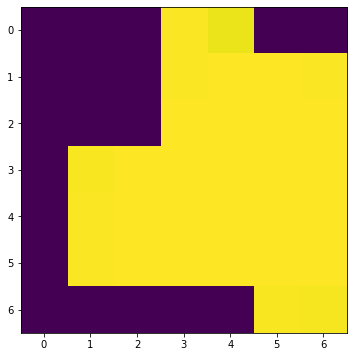

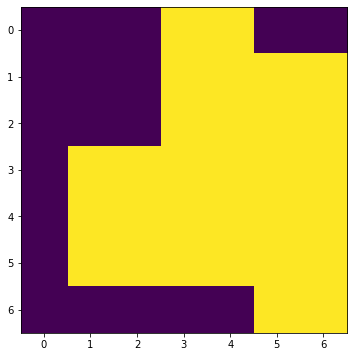

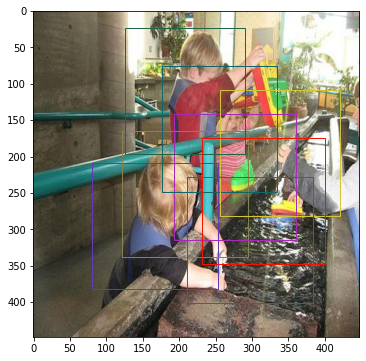

In [ ]:

# pp,im = load_test(i)
for x,y in train:
  break
i =1
b = detect(np.array([x[i]]))
show_detected_area([y[i]])
print(b)
# show_image_with_rect_wh(pp,decode([outputs[i+1]]))
show_image_with_rect_xy(x[i],b,minus=True)
# show_image_with_rect_wh(pp,m)
# show_image_with_rect_wh(pp,l)




In [ ]:
# import os
# %cd /content/drive/My\ Drive/my_data_set/train/human

# os.system("for l in `ls |head -20000` ;do mv $l ../../temp2;done")
# %cd ../
# s = os.popen("ls human | wc -l")
# s2 = os.popen("ls not_human | wc -l")
# print(s.read(),s2.read())
# 1058
#  1101

In [ ]:
a = np.array([[[-1.0, 1.0], [2., -2.],[3.,-3.]],
              [[-1.0, 1.0], [2., -2.],[3.,-3.]],
              [[-1.0, 1.0], [2., -2.],[3.,-3.]]])
a = tf.constant(a)

b = np.array([[[-1.5, 1.0], [2., 2.],[3.5,3.5]],
              [[-1.5, 1.0], [2., 2.],[3.5,3.5]],
              [[-1.5, 1.0], [2., 2.],[3.5,3.5]]])
b = tf.constant(b)

c = tf.where(a>0,a,0)
print(c)
# print(a * [1,2])

tf.Tensor(
[[[0. 1.]
  [2. 0.]
  [3. 0.]]

 [[0. 1.]
  [2. 0.]
  [3. 0.]]

 [[0. 1.]
  [2. 0.]
  [3. 0.]]], shape=(3, 3, 2), dtype=float64)


#unit test

model created
(448, 448, 3)
detect  in:  864  ms
detect  in:  644  ms


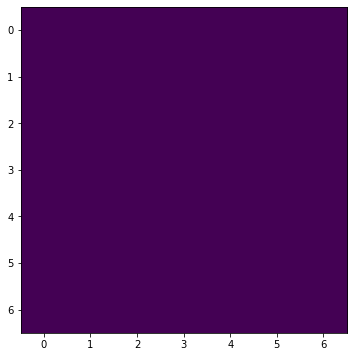

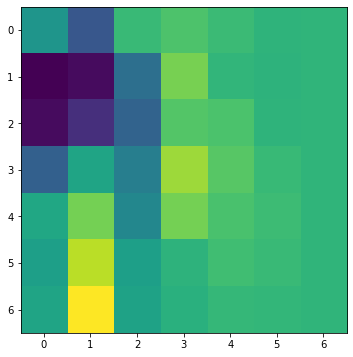

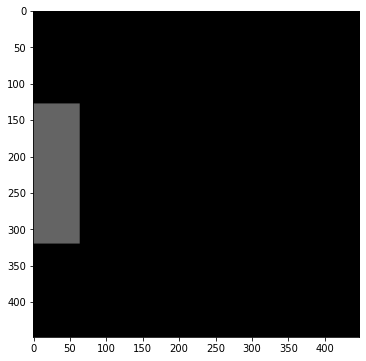

In [ ]:
model = get_yolo_model(IR=1.1e-2)
utest_input = np.array([[[0,0,0] for _ in range(448)]for _ in range(448)])
print(utest_input.shape)

def fill(inp,x,y):
  for i in range(64):
    for j in range(64):
      inp[64*x + i][64*y+j] = 100

out1 = detect(np.array([utest_input]))
# fill(utest_input,0,0)
# fill(utest_input,1,0)
fill(utest_input,2,0)
fill(utest_input,3,0)
fill(utest_input,4,0)
# fill(utest_input,5,0)
out2 = detect(np.array([utest_input]))
show_image_with_rect_wh(utest_input,[])



In [ ]:
%rm -r /content/t/.ipynb_checkpoints

In [ ]:
def non_max(outputs):
  ro = []
  outputs = outputs[:]
  sort_output = sorted(outputs,key=lambda x:x[4],reverse=True)
  deny = []
  for i in range(len(sort_output)) :
    if i in deny:
      continue
    loc = sort_output[i][:4]
    ro.append(loc)
    for box in reversed(outputs):
      if get_iou(loc,box[:4]) > .45:
        outputs.remove(box)
        deny.append(sort_output.index(box))
    print(i,deny)
    
  return ro

